I'll be building a model with the custom dataset from the previous file

In [5]:
from pathlib import Path
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from torch import nn
from PIL import Image
from typing import Tuple, Dict, List
data_path = Path("pizza_steak_sushi")
train_path = data_path / "train"
test_path = data_path / "test"


In [22]:
# Creating ImageFolder
class ImageFolderCustom(Dataset):
    def __init__(self, dir:str, transform=None):
        self.paths = list(Path(dir).glob("*/*.jpg"))
        self.class_names = sorted([clas.name for clas in os.scandir(dir)])
        self.class_names_dict = {key:num for num,key in enumerate(self.class_names)}
        self.transform = transform
    
    def load_image(self, index:int):
        return Image.open(self.paths[index])

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index:int):
        image = self.load_image(index)
        image_class = self.paths[index].parent.name
        image_label = self.class_names_dict[image_class]

        if self.transform:
            return self.transform(image), image_label
        else:
            return image, image_class

In [23]:
custom_train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()]
)

custom_test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()]
)

In [24]:
train_data = ImageFolderCustom(dir=train_path, transform=custom_train_transform)
test_data = ImageFolderCustom(dir=test_path, transform=custom_test_transform)

In [ ]:
# Put it into a DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True,)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True,)

torch.Size([1, 3, 64, 64])

In [62]:
class CustomDModule(nn.Module):
    def __init__(self, input_shape:int, hidden_layer:int,output_layer:int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_layer, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer, out_channels=hidden_layer, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layer*256, out_features=output_layer)
            )
    
    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))
model = CustomDModule(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_layer=10, 
                  output_layer=len(train_data.class_names))
model

CustomDModule(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [63]:
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
CustomDModule                            [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [68]:
# Creating training and testing loops
from tqdm.auto import tqdm
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               optim:torch.optim.Optimizer,
               loss_fn=nn.CrossEntropyLoss()):
    train_loss, train_acc =0,0
    model.train()
    for X,y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        train_acc += (torch.eq(torch.argmax(pred, dim=1), y).sum().item()) / len(pred)
        optim.zero_grad()
        loss.backward()
        optim.step()
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn=nn.CrossEntropyLoss()):
    test_loss, test_acc =0,0
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_acc += (torch.eq(torch.argmax(pred, dim=1), y).sum().item()) / len(pred)
        test_loss = test_loss/len(dataloader)
        test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optim:torch.optim.Optimizer,
          loss_fn=nn.CrossEntropyLoss(),
          epochs=5):
    
    results = {"Train Loss":[],
               "Train Accuracy":[],
               "Test Loss":[],
               "Test Accuracy":[]}

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_step(model=model,
                   dataloader=train_dataloader,
                   optim=optim)
        test_loss,test_acc=test_step(model=model,
                  dataloader=test_dataloader)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["Train Loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["Train Accuracy"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["Test Loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["Test Accuracy"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    return results

In [69]:
model = CustomDModule(input_shape=3, hidden_layer=10, output_layer=len(train_data.class_names))
optim = torch.optim.Adam(params=model.parameters(), lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optim=optim,
                      )
end_time = timer()
print(f"Total train time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1041 | train_acc: 0.3600 | test_loss: 1.1737 | test_acc: 0.4133
Epoch: 2 | train_loss: 1.1104 | train_acc: 0.2889 | test_loss: 1.1004 | test_acc: 0.3733
Epoch: 3 | train_loss: 1.1045 | train_acc: 0.3511 | test_loss: 1.1013 | test_acc: 0.2000
Epoch: 4 | train_loss: 1.1018 | train_acc: 0.3333 | test_loss: 1.1002 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0991 | train_acc: 0.3333 | test_loss: 1.1008 | test_acc: 0.3333
Total train time: 29.033 seconds


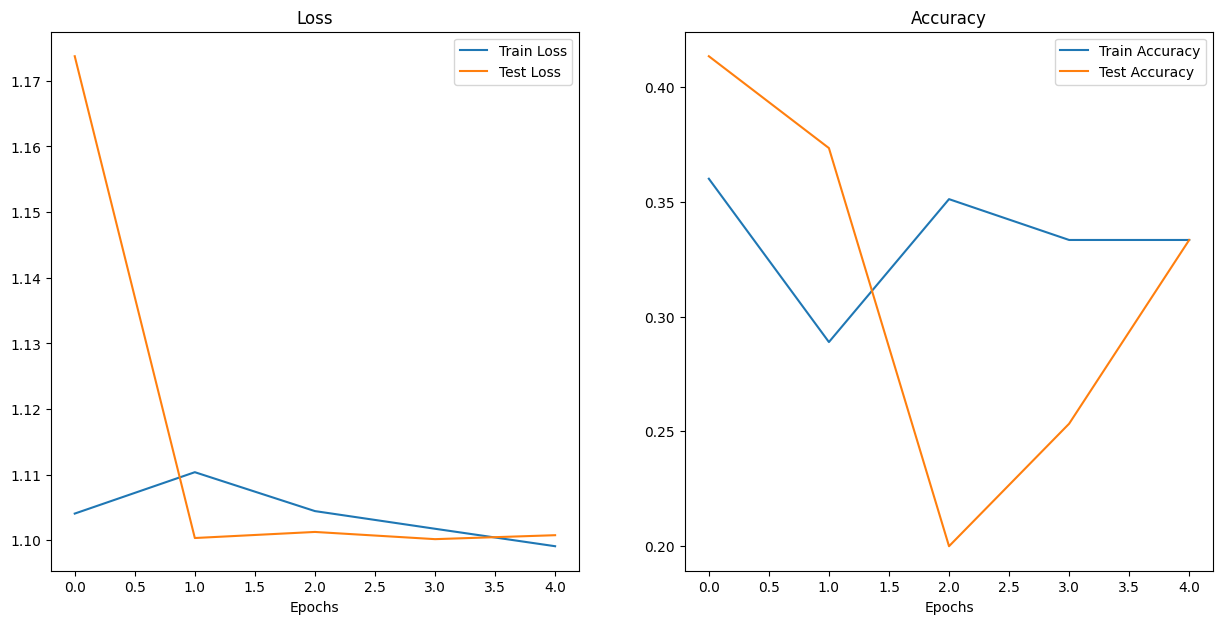

In [72]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"Train Loss": [...],
             "Train Accuracy": [...],
             "Test Loss": [...],
             "Test Accuracy": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['Train Loss']
    test_loss = results['Test Loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['Train Accuracy']
    test_accuracy = results['Test Accuracy']

    # Figure out how many epochs there were
    epochs = range(len(results['Train Loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(results=model_results)

### Testing the model on a custom dataset

In [133]:
img_path = Path("sushi.jpeg")
custom_img = torchvision.io.read_image((img_path))
custom_img = (custom_img/255).type(torch.float32)


In [135]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64))
])
custom_img = simple_transform(custom_img).unsqueeze(dim=0)

In [136]:
custom_img.shape

torch.Size([1, 3, 64, 64])

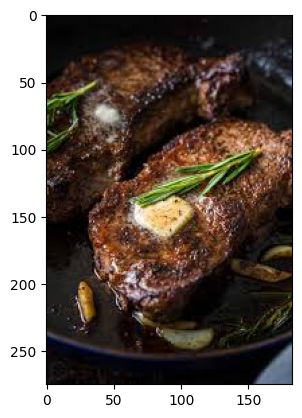

In [134]:
plt.imshow(custom_img.permute(1, 2, 0))

In [139]:
model.eval()
with torch.inference_mode():
    custom_img_class = model(custom_img)
torch.softmax(custom_img_class, dim=1)

tensor([[0.3373, 0.3357, 0.3270]])

In [138]:
train_data.class_names[custom_img_class.argmax().item()]

'pizza'

It seems the model output weights are almost equal

This could only mean the model doesn't know what to predict and is just assigning similar values toeach of the classes

So basically it's poorly trained and is just making _baseless predictions_


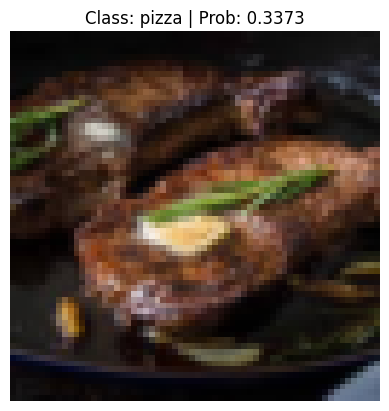

In [154]:
# Making a function to make predictions and plot custom images
def make_plot_predictions(model:torch.nn.Module,
                          img_path:str,
                          transform=None,
                          class_names:List[str]=None):
    img = torchvision.io.read_image(img_path)
    img = (img/255).type(torch.float32)
    img = transform(img).unsqueeze(dim=0)

    model.eval()
    with torch.inference_mode():
        pred_img = model(img)
    pred_img_label = torch.argmax(pred_img)
    pred_img_prob = torch.softmax(pred_img, dim=1)
    pred_img_class = class_names[pred_img_label]
    plt.axis("off")

    plt.imshow(img.squeeze().permute(1,2,0))
    plt.title(f"Class: {pred_img_class} | Prob: {pred_img_prob.max():.4f}")
make_plot_predictions(model=model, img_path=img_path, transform=simple_transform, class_names=train_data.class_names)